## Fundamentals of Artificial Intelligence and Knowledge Representation 
## Module 3
### Members of the group for this project:
#### - Dell'Olio Domenico - ID: 0001037814 - domenico.dellolio@studio.unibo.it
#### - Delvecchio Giovanni Pio - ID: 0001037185 - giovanni.delvecchio2@studio.unibo.it
#### - Disabato Raffaele - ID: 0001057619 - raffaele.disabato@studio.unibo.it

## 0. Introduction

The project consists in the use of a dataset containing records that represent a possible client of a bank, the target variable is a boolean representing the trustworthiness (high or low risk) of the client itself.
Both the description of the dataset and its preprocessing are described in the <code>data_preprocessing.ipynb</code> notebook.

The following steps have been made:
1. to obtain a correlation matrix using the chi-squared test, in order to spot which variables are more likely to be connected in a Bayesian Network;
2. to design an ordering for the features of the dataset, in order to construct a Bayesian Network that guarantees the global semantics;
3. to use that same ordering to construct an initial Bayesian Network where the edges are inserted partly because of common sense and partly because of the correlation matrix;
4. to feed the ordering of the features to the hillclimbing algorithm to construct a Bayesian Network;
5. to compare the Networks using scores (e.g. the BIC score) and choose one;
6. to illustrate the concept of "Markov Blanket" over the chosen network;
7. to illustrate the concept of "Flow of Probabilistic Influence" over the chosen network;
8. to show examples of conditional probability tables;
9. to show examples of queries in exact inference;
10. to show examples of queries in approximate inference (rejection sampling and likelihood weighting as sampling methods) and to compare them to the queries in exact inference.

In [3]:
# pgmpy installation command
!pip install pgmpy
# tabulate installation command
!pip install tabulate

You should consider upgrading via the 'c:\users\neo dom-z mk. ii\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\neo dom-z mk. ii\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [4]:
# imports

from pgmpy.estimators.CITests import chi_square
from pgmpy.estimators import BicScore
import pandas as pd
import numpy as np
from pgmpy.estimators import HillClimbSearch, BayesianEstimator
from pgmpy.base import DAG
from pgmpy.models import BayesianNetwork
import networkx as nx
from pgmpy.inference import VariableElimination, ApproxInference
import matplotlib.pyplot as plt
from pgmpy.inference import ApproxInference
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
from tabulate import tabulate
import itertools
import time

In [5]:
# dataset loading

df = pd.read_csv("data/processed.csv")
print(df.shape)
df.head()

(9709, 12)


,Gender,Own_car,Own_property,Unemployed,Num_family,Account_length,Total_income,Age,Income_type,Education_type,Family_status,Target
0,M,yes,yes,no,2,1y-2y,high,30-39,Working,Higher education,Civil marriage,high risk
1,M,yes,yes,no,2,2y-3y,low,50-59,Working,Secondary / secondary special,Married,low risk
2,F,no,yes,no,1,<1y,high,50-59,Commercial associate,Secondary / secondary special,Single / not married,low risk
3,F,no,yes,yes,1,1y-2y,high,60>=,Pensioner,Higher education,Separated,low risk
4,M,yes,yes,no,2,<1y,high,40-49,Working,Higher education,Married,low risk


## 1. Correlation Matrix 

In order to understand how each pair of features are correlated with eachother, we decided to apply the chi-squared test between two variables contained in pgmpy.
In particular the chi-squared test has the objective to confirm or deny the null hypotesis that two variables are independent from each other given some evidence, quoting pgmpy documentation itself:

_"This is done by comparing the observed frequencies with the expected frequencies if X,Y were conditionally independent, using a chisquare deviance statistic. The expected frequencies given independence are `P(X,Y,Zs) = P(X|Zs)*P(Y|Zs)*P(Zs)`. The latter term can be computed as `P(X,Zs)*P(Y,Zs)/P(Zs)`."_ 

The test returns a p-value, which is the probability of observing the computed chi-square statistic, if the p-value is higher than a certain significance level, then we can consider the null hypotesis true (there is conditional independence), otherwise we consider it false.
We decided to take a look to the correlation matrix directly instead of choosing a threshold, this in order to have a more general picture of the correlation values.

Here is presented the matrix containing the logarithm of the p-values between each pair of features, this because of a readability reason (we obtained values really close to 0). Based on the computed values, it's possible to assert if there's correlation between pairs of variables (without considering evidences).

In [6]:
cols = df.columns
p_values = np.zeros((len(cols), len(cols)))
for first_index, first_col_val in enumerate(cols): 
    for second_index, second_col_val in enumerate(cols):
        if first_index != second_index:
            (chi, p_value, dof) = chi_square(first_col_val, second_col_val, [], df, False)
            p_values[first_index, second_index] = p_value

display(pd.DataFrame(p_values, columns=cols, index=cols).apply(np.log)) 

,Gender,Own_car,Own_property,Unemployed,Num_family,Account_length,Total_income,Age,Income_type,Education_type,Family_status,Target
Gender,-inf,-616.245837,-17.096983,-140.816843,-34.306838,-2.642767,-218.265421,-135.953926,-156.408439,-2.182859,-119.955992,-1.916548
Own_car,-616.245837,-inf,-1.120036,-105.255566,-115.074168,-4.957653,-234.176494,-94.975367,-102.104702,-45.296526,-120.785831,-0.646807
Own_property,-17.096983,-1.120036,-inf,-38.607448,-0.942559,-1.855561,-3.633053,-75.401218,-34.515093,-2.647412,-6.636110,-5.121073
Unemployed,-140.816843,-105.255566,-38.607448,-inf,-284.349571,-1.880717,-151.561694,-inf,-inf,-95.578866,-222.627612,-4.156378
Num_family,-34.306838,-115.074168,-0.942559,-284.349571,-inf,-6.483826,-1.679563,-inf,-263.218627,-8.488100,-inf,-0.488970
Account_length,-2.642767,-4.957653,-1.855561,-1.880717,-6.483826,-inf,-3.426799,-44.705565,-5.788770,-0.243947,-15.158806,-27.701160
Total_income,-218.265421,-234.176494,-3.633053,-151.561694,-1.679563,-3.426799,-inf,-105.018060,-211.925720,-233.079550,-8.921277,-0.499245
Age,-135.953926,-94.975367,-75.401218,-inf,-inf,-44.705565,-105.018060,-inf,-inf,-200.761365,-494.049234,-5.911174
Income_type,-156.408439,-102.104702,-34.515093,-inf,-263.218627,-5.788770,-211.925720,-inf,-inf,-164.712017,-203.435712,-0.744493
Education_type,-2.182859,-45.296526,-2.647412,-95.578866,-8.488100,-0.243947,-233.079550,-200.761365,-164.712017,-inf,-37.841776,-2.266519


## 2. Design an ordering for the features

We start by imposing an order on the list of attributes. The main idea is to follow a causal-relation order (so that causes precede effect) and to give a higher position in the order to attributes that should be less related to the problem at hand. 

In fact, we ordered first personal information about the individual, then information about its job and finally about its physical possessions and credit-card-releated information.

In [7]:
ordered_list_of_attr = [
    "Gender",
    "Age",
    "Family_status",
    "Num_family",
    "Education_type",
    "Income_type",
    "Unemployed",
    "Total_income",
    "Own_property",
    "Own_car",
    "Account_length",
    "Target"
]

## 3. Construction of a Bayesian Network by hand

In order to construct the Bayesian Network we decided to use the previously defined ordering in order to have a guideline for where to put the nodes, while we decided the inclusion of each edge based on the chi-squared results and/or on our common sense, e.g. the edge <code>("Education_type", "Income_type")</code> means we believe that the type of education that one has recieved can influence its actual income, this is confirmed by the fact that with respect to the other values of the table, the log of the p value is quite low, meaning that there's correlation.

In [8]:
# NetworkX draw parameters
draw_node_size     = 9000
draw_width         = 3
draw_arrow_size    = 30
plot_figsize_model = (20, 12.5)

# Hillclimb parameters
hc_max_iter     = 100
hc_max_indegree = 3

Number of edges: 18


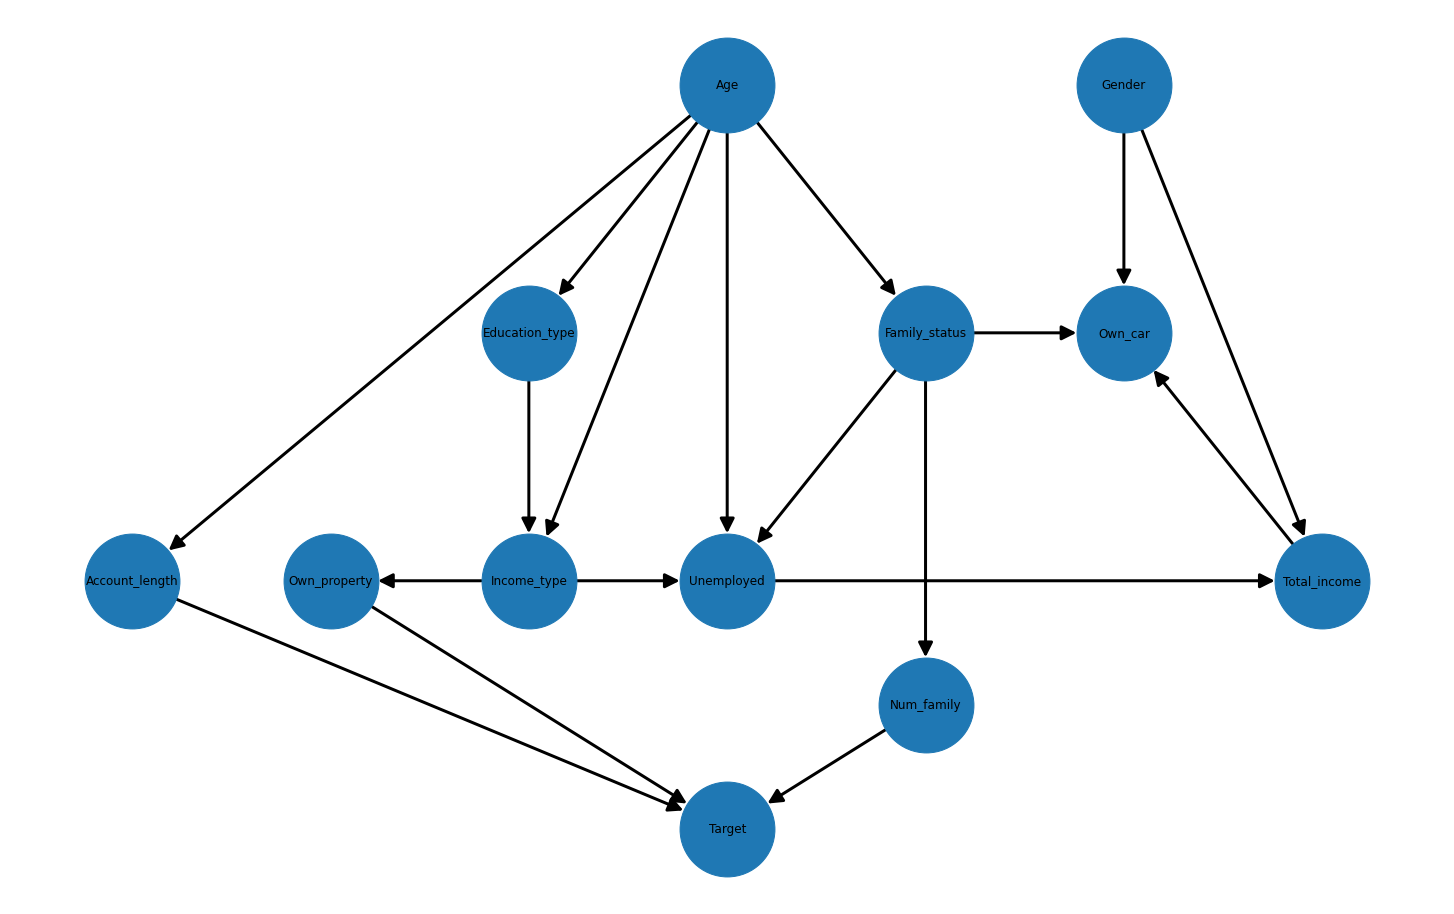

In [9]:
edges = [
    ("Gender", "Own_car"),
    ("Gender", "Total_income"),
    ("Age", "Education_type"),
    ("Age", "Income_type"),
    ("Age", "Unemployed"),
    ("Age", "Family_status"),
    ("Age", "Account_length"),
    ("Family_status", "Unemployed"),
    ("Family_status", "Own_car"),
    ("Family_status", "Num_family"),
    ("Num_family", "Target"),
    ("Education_type", "Income_type"),
    ("Income_type", "Unemployed"),
    ("Income_type", "Own_property"),
    ("Unemployed", "Total_income"),
    ("Total_income", "Own_car"),
    ("Own_property", "Target"),
    ("Account_length", "Target"),
]

bic_score = BicScore(df)
hand_net = BayesianNetwork(edges)
print("Number of edges: " + str(len(edges)))

plt.figure(figsize=plot_figsize_model)
pos = {
    "Gender": (5,5),
    "Age": (3,5),
    "Total_income": (6,3),
    "Income_type": (2,3),
    "Education_type": (2,4),
    "Num_family": (4,2.5),
    "Account_length": (0,3),
    "Own_property": (1,3),
    "Unemployed": (3,3),
    "Own_car": (5,4),
    "Family_status": (4,4),
    "Target": (3,2)
}

nx.draw(hand_net, pos=pos, with_labels=True, node_size=draw_node_size, width=draw_width, arrowsize=draw_arrow_size)

## 4. Construction of a Bayesian Network through Hillclimbing search

Then we try to improve our net by running the hillclimb algorithm proposed by pgmpy. It performs a heuristic search by applying changes to the network until a local maximum for the chosen score, in our case the BIC score, is reached.

In particular the BIC (Bayesian Information Criterion) score is a log-likelihood score with an additional penalty for network complexity, to avoid overfitting.  
The score measures how well a model is able to describe the given data set.
The BIC scoring function is defined as:

$ \phi(B \mid T) = LL(B \mid T) - f(N) * \vert B \vert  $

where:
- B is the Bayesian Network;
- T is the given Data;
- LL is the log-likelihood of the Bayesian Network given the data;
- N is the number of records in the dataset
- |B| is the number of parameter in the network (network complexity).
- $f(N)$ is the penalty function $ \frac{1}{2}*log(N) $;

(reference: http://www.lx.it.pt/~asmc/pub/talks/09-TA/ta_pres.pdf)
<br>The documentation for <code>bic_score</code> asserts that a model with a higher score fits the data better, however this is the opposite behaviour with respect to how it is described in other sources, which adopt the common definition of optimization problem as minimization of an objective function.

In order to have a reference net, we apply simply the algorithm without doing any tuning, except by limiting the number of maximum parents (<code>max_indegree</code> parameter). This limitation avoids nets that are too complex.

  0%|          | 0/100 [00:00<?, ?it/s]

Number of edges: 17
Removed Edges:
{('Age', 'Education_type'), ('Age', 'Unemployed'), ('Total_income', 'Own_car'), ('Age', 'Account_length'), ('Family_status', 'Num_family'), ('Income_type', 'Own_property'), ('Unemployed', 'Total_income'), ('Num_family', 'Target'), ('Education_type', 'Income_type'), ('Own_property', 'Target'), ('Family_status', 'Unemployed'), ('Age', 'Income_type'), ('Family_status', 'Own_car')}
Added_edges:
{('Age', 'Own_property'), ('Own_car', 'Total_income'), ('Total_income', 'Education_type'), ('Gender', 'Age'), ('Num_family', 'Family_status'), ('Gender', 'Income_type'), ('Unemployed', 'Education_type'), ('Age', 'Num_family'), ('Target', 'Unemployed'), ('Total_income', 'Income_type'), ('Unemployed', 'Age'), ('Gender', 'Num_family')}


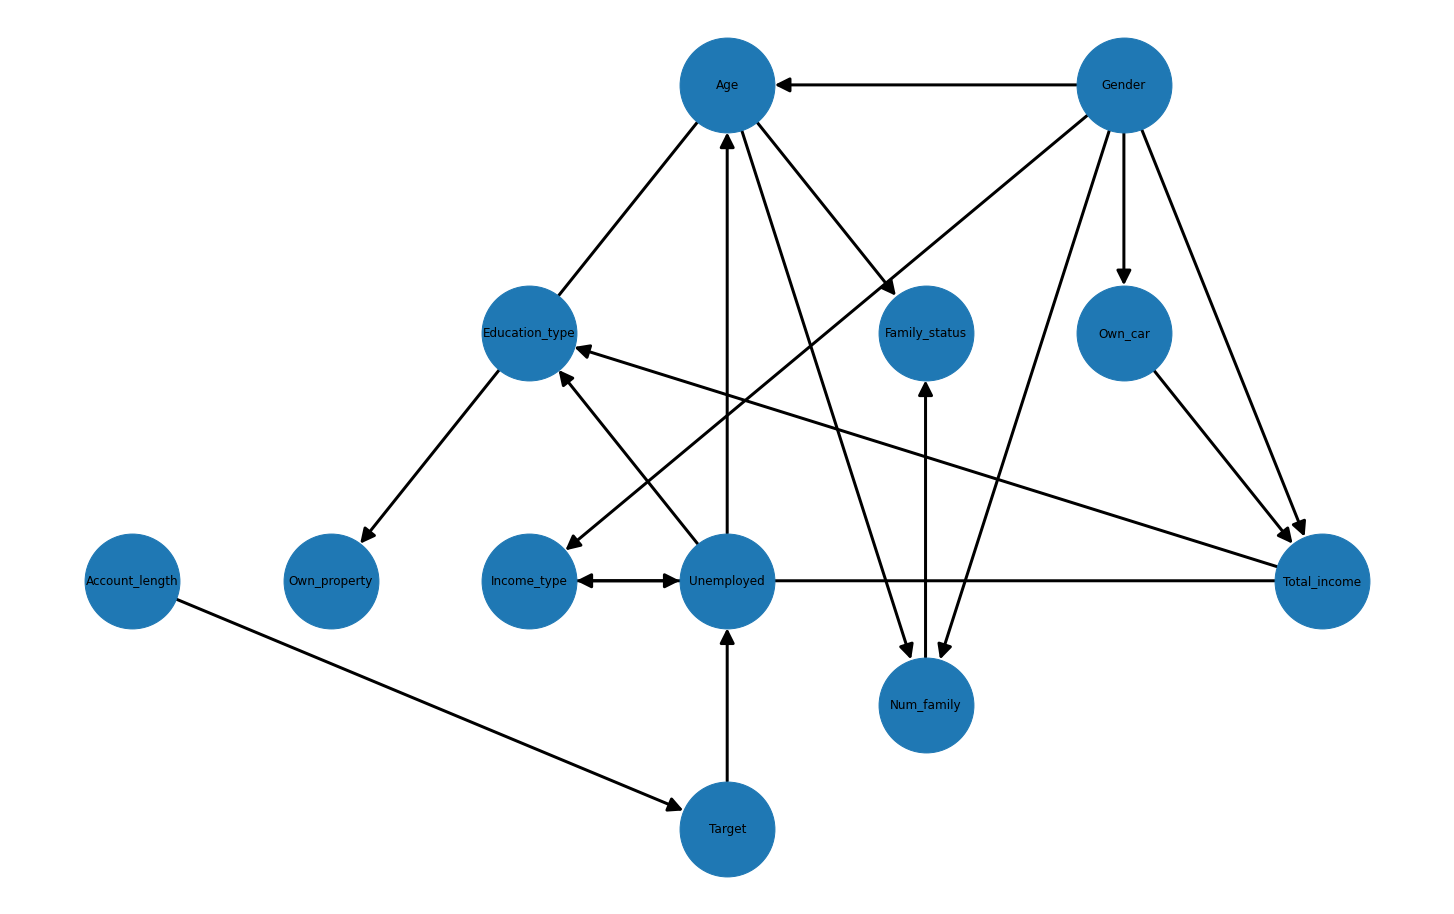

In [10]:
# creating the estimator object
hillclimb_estimator = HillClimbSearch(df)
# obtaining the reference net
hillclimb_model = hillclimb_estimator.estimate(scoring_method=bic_score, max_iter=hc_max_iter, max_indegree=hc_max_indegree)

# plotting the net
plt.figure(figsize=plot_figsize_model)
nx.draw(hillclimb_model, pos=pos, with_labels=True, node_size=draw_node_size, width=draw_width, arrowsize=draw_arrow_size)
hillclimb_net_first = BayesianNetwork(hillclimb_model)

#showing differences wrt the handmade net
print("Number of edges: " + str(len(hillclimb_model.edges)))
print("Removed Edges:")
print(edges - hillclimb_model.edges)
print("Added_edges:")
print(hillclimb_model.edges - edges)


In order to provide an alternative to our net that sticks more on the relations that may emerge from the dataset, the method will start from our designed network and will try to add or remove the edges in order to optimize the BIC score of the net. In doing so, it will still consider the causal-order we imposed, in order to avoid relation that are too strange to interpret.

In [11]:
# creating the blacklist of edges that allows to keep the order we originally decided
black_list = []
for i in range(len(ordered_list_of_attr)):
    for j in range(0, i):
        black_list.append((ordered_list_of_attr[i], ordered_list_of_attr[j]))

start_dag = DAG()
start_dag.add_edges_from(ebunch=edges)
# obtaining the new net
hillclimb_model = hillclimb_estimator.estimate(scoring_method=bic_score, start_dag=start_dag, black_list=black_list, max_iter=hc_max_iter, max_indegree=hc_max_indegree)
hillclimb_net_blacklist = BayesianNetwork(hillclimb_model.edges)

print("Number of edges: " + str(len(hillclimb_model.edges)))
print("Removed Edges:")
print(edges - hillclimb_model.edges)
print("Added_edges:")
print(hillclimb_model.edges - edges)

  0%|          | 0/100 [00:00<?, ?it/s]

Number of edges: 18
Removed Edges:
{('Age', 'Unemployed'), ('Num_family', 'Target'), ('Own_property', 'Target'), ('Education_type', 'Income_type'), ('Family_status', 'Unemployed'), ('Family_status', 'Own_car')}
Added_edges:
{('Gender', 'Family_status'), ('Gender', 'Age'), ('Num_family', 'Own_car'), ('Age', 'Num_family'), ('Gender', 'Income_type'), ('Education_type', 'Total_income')}


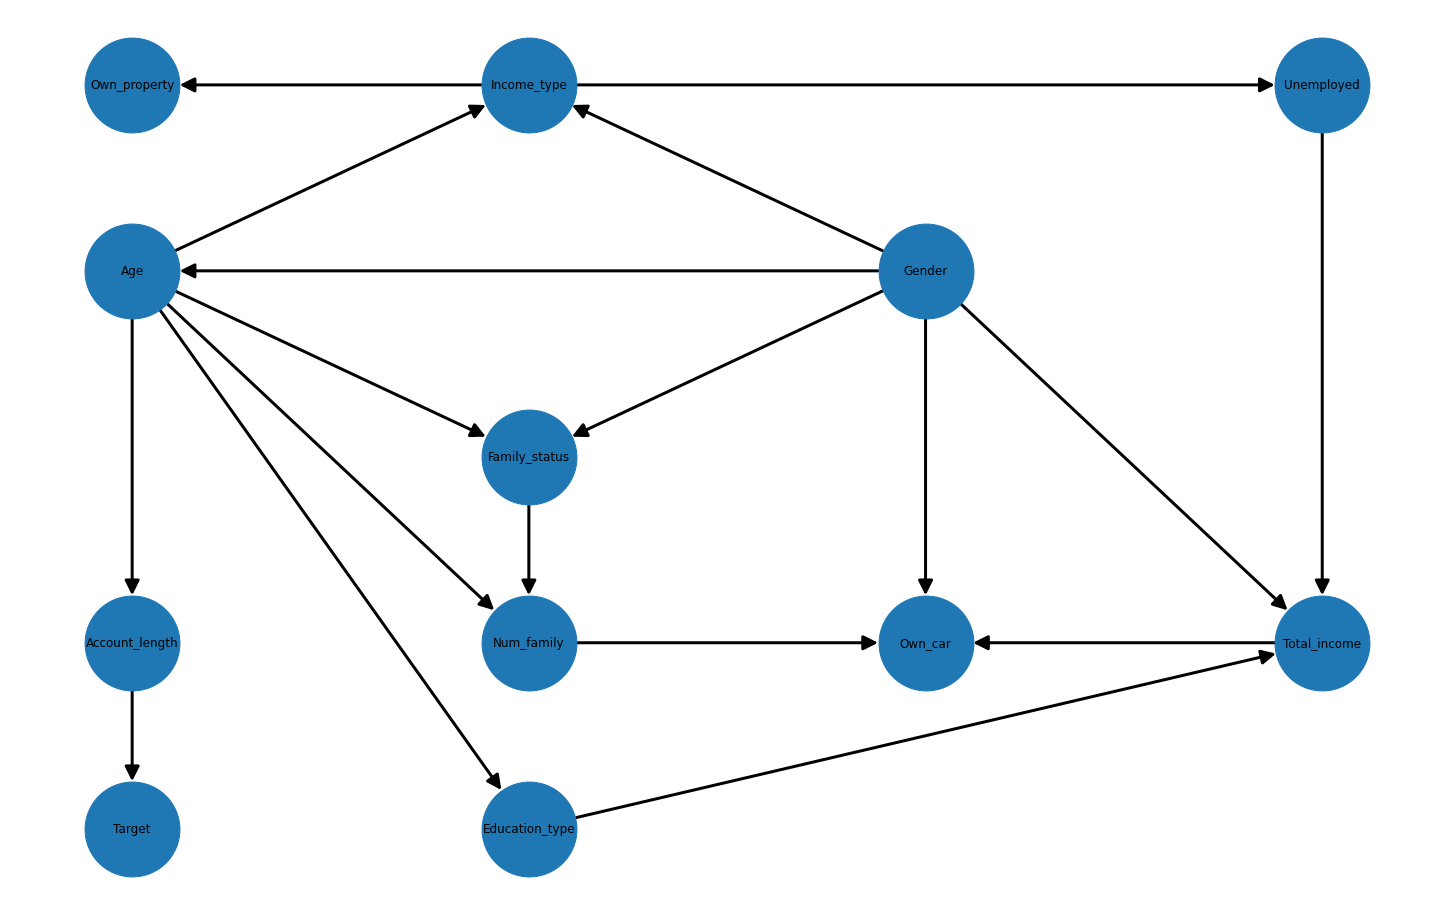

In [12]:
plt.figure(figsize=plot_figsize_model)
pos_hc = pos.copy()
pos_hc["Num_family"]     = (4,3)
pos_hc["Total_income"]   = (6,3)
pos_hc["Income_type"]    = (4,6)
pos_hc["Own_property"]   = (3,6)
pos_hc["Own_car"]        = (5,3)
pos_hc["Unemployed"]     = (6,6)
pos_hc["Education_type"] = (4,2)
pos_hc["Target"]         = (3,2)
pos_hc["Account_length"] = (3,3)

nx.draw(hillclimb_model, pos=pos_hc, with_labels=True, node_size=draw_node_size, width=draw_width, arrowsize=draw_arrow_size)

Here we present a network obtained by the application of hillclimbing, but without feeding to the algorithm the Network built by hand:

In [13]:
hillclimb_model_nostart = hillclimb_estimator.estimate(scoring_method=bic_score, black_list=black_list, max_iter=hc_max_iter, max_indegree=hc_max_indegree)
hillclimb_net_nostart = BayesianNetwork(hillclimb_model_nostart)

print("Number of edges:" + str(len(hillclimb_model_nostart.edges)))
print("Removed Edges:")
print(edges- hillclimb_model_nostart.edges)
print("Added_edges:")
print(hillclimb_model_nostart.edges-edges)

  0%|          | 0/100 [00:00<?, ?it/s]

Number of edges:18
Removed Edges:
{('Age', 'Unemployed'), ('Income_type', 'Own_property'), ('Num_family', 'Target'), ('Education_type', 'Income_type'), ('Own_property', 'Target'), ('Family_status', 'Unemployed'), ('Family_status', 'Own_car')}
Added_edges:
{('Gender', 'Family_status'), ('Age', 'Own_property'), ('Gender', 'Age'), ('Num_family', 'Own_car'), ('Age', 'Num_family'), ('Gender', 'Income_type'), ('Education_type', 'Total_income')}


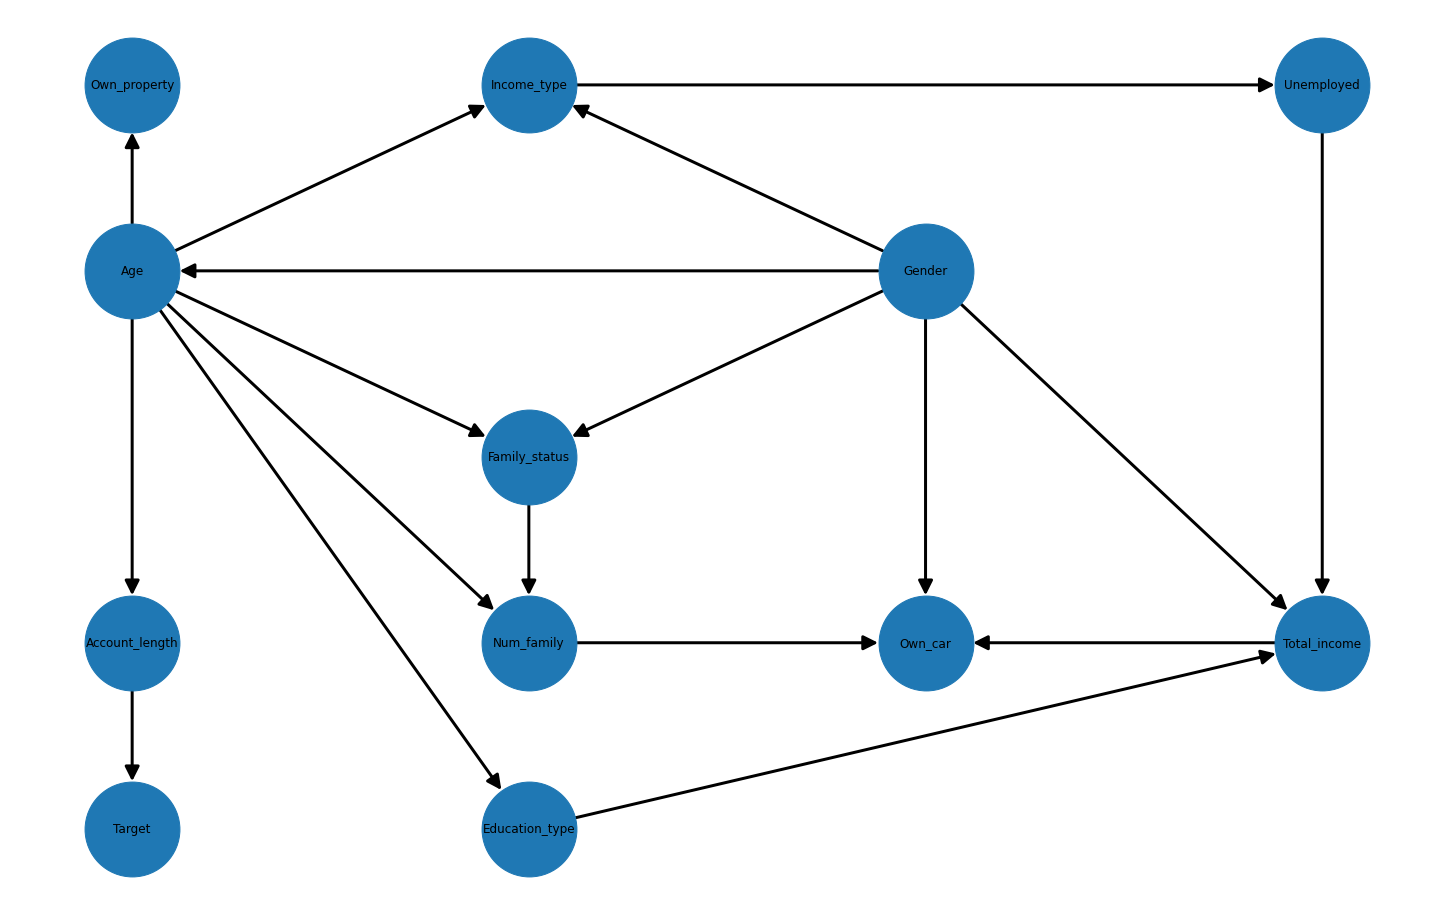

In [14]:
plt.figure(figsize=plot_figsize_model)
nx.draw(hillclimb_model_nostart, pos=pos_hc, with_labels=True, node_size=draw_node_size, width=draw_width, arrowsize=draw_arrow_size)

We can see that the only difference with the previous net is the edge Age $\to$ Own_property that was switched with Income_type $\to$ Own_property. This very small improvement suggests us that most of the improvement on the interpretability side of the net was brought by the addition of the blacklist, rather than by the suggestion of the inital topology of the net.

## 5. Comparing the Networks

Together with the structure, also the parameters are estimated from data. Since there may be some specific combination of variable and parents states that are not represented in the dataset and may be improbable but not impossible, instead of using a simple <code>MaximumLikelihoodEstimator</code> we employed a <code>BayesianEstimator</code>. The first estimates the CPTs by simply computing the relative frequencies of each combination of values of a variable and the ones of its parents, while the second allows to insert some kind of prior information through pseudo-counts. As we don't have any information on prior distribution of the variables in the dataset, we opted for a uniform prior with <code>pseudo-counts=5</code>, thus applying a _laplace smoothing_ on the probabilities:

In [15]:
pseudo_count_param = 5
hand_net.fit(df, estimator=BayesianEstimator, prior_type="dirichlet", pseudo_counts = pseudo_count_param)
hillclimb_net_first.fit(df, estimator=BayesianEstimator, prior_type="dirichlet", pseudo_counts = pseudo_count_param)
hillclimb_net_blacklist.fit(df, estimator=BayesianEstimator, prior_type="dirichlet", pseudo_counts = pseudo_count_param)
hillclimb_net_nostart.fit(df, estimator=BayesianEstimator, prior_type="dirichlet", pseudo_counts = pseudo_count_param)

Here we present the number of parameters and the resulting BIC scores for each network in order to compare them:

In [16]:
get_num_parameters = lambda model: sum([len(cpd.get_values().ravel()) for cpd in model.get_cpds()])

print("Number of parameters in handmade network: {}".format(get_num_parameters(hand_net)))
print("Number of parameters in hillclimb baseline network: {}".format(get_num_parameters(hillclimb_net_first)))
print("Number of parameters in hillclimb refined network: {}".format(get_num_parameters(hillclimb_net_blacklist)))
print("Number of parameters in hillclimb refined network, without starting architecture: {}".format(get_num_parameters(hillclimb_net_nostart)))


# N.B. the documentation for bic_score asserts that a model with a higher score fits the data better

print("Bic score for handmade network: {}".format(bic_score.score(hand_net)))
print("Bic score for hillclimb baseline network: {}".format(bic_score.score(hillclimb_net_first)))
print("Bic score for hillclimb refined network: {}".format(bic_score.score(hillclimb_net_blacklist)))
print("Bic score for hillclimb refined network, without starting architecture: {}".format(bic_score.score(hillclimb_net_nostart)))

Number of parameters in handmade network: 618
Number of parameters in hillclimb baseline network: 280
Number of parameters in hillclimb refined network: 393
Number of parameters in hillclimb refined network, without starting architecture: 393
Bic score for handmade network: -95840.6874860322
Bic score for hillclimb baseline network: -93602.78284399933
Bic score for hillclimb refined network: -93762.40671500452
Bic score for hillclimb refined network, without starting architecture: -93721.88581521904


The resulting BIC scores point out that the networks with less starting informations fit the most (baseline and without starting architecture), but a quick observation of those networks is enough to decide that are not a good choice (e.g. in the baseline the influence of "Target", "Unemployed", "Total_income"...  and in the other net, the previously mentioned "edge switch"). Thus the remaining choice is between the handmade network and the refined one, the BIC score and the lower number of parameters point out that it's appropriate to choose the refined network (<code>hillclimb_net_blacklist</code>)

## 6. Markov Blanket
Given a node in a Bayesian Network, his Markov Blanket is defined as
- The node
- The parents of the node
- The children of the node
- The parents of the children of the node
In a Bayesian Network each node is conditionally independent of all others given its Markov Blanket.

So here it's defined a function that takes in input the network and a node, in order to construct and draw its Markov Blanket, where
- **The red node** is the **main node**, given in input
- **Blue nodes** are the **parents** of the main node
- **Green nodes** are the **children** of the main node
- **Yellow nodes** are the **parents of the children** nodes of the main node
This function uses the <code>get_markov_banket</code> function of pgmpy in order to retrieve the Markov Blanket of a given node, then it filters the edges in order to keep only the imporant ones for the blanket.

In [17]:
def draw_markov_blanket(net, node_name):
    markov_nodes = net.get_markov_blanket(node_name)
    
    father_edges = []
    son_edges = []
    for elem in markov_nodes:
        if (elem, node_name) in net.edges:
            father_edges.append((elem, node_name))
        elif (node_name, elem) in net.edges:
            son_edges.append((node_name, elem))
    fathers_of_sons = []
    for son_link in son_edges:
        child = son_link[1]
        for link in net.edges:
            if link[0] != node_name and link[1] == child:
                fathers_of_sons.append(link)

    markov_nodes.append(node_name)
    position = dict()
    n_parents = len(father_edges)
    n_children = len(son_edges)
    
    filtered_edges = father_edges + son_edges + fathers_of_sons
    i = int(0 - (n_parents/2))
    j = int(0 - (n_children/2))
    k = int(1 - ((len(filtered_edges)-n_parents-n_children)/2))
    nodes_colors = []
    for n in markov_nodes:
        if (n,node_name) in father_edges:
            position[n] = (i,1)
            nodes_colors.append("tab:blue")
            i = i + 1 
        elif n == node_name:
            position[node_name] = (0,0)
            nodes_colors.append("tab:red")
        elif (node_name, n) in son_edges:
            position[n] = (j,-1)
            nodes_colors.append("tab:green")
            j = j + 1
        else:
            if k == 0:
                k = k + 1
            position[n] = (k,0)
            nodes_colors.append("yellow")
            k = k + 1
    
    markov_blanket = DAG()
    markov_blanket.add_nodes_from(nodes=markov_nodes)
    markov_blanket.add_edges_from(ebunch=filtered_edges)
    plt.figure(figsize=(15,8))
    nx.draw(markov_blanket,node_color=nodes_colors, pos=position, width=2,
            with_labels=True, node_size=9000, arrowsize=20)

Example of the function with the black list network and the node "**Total_income**" as main node of the markov blanket

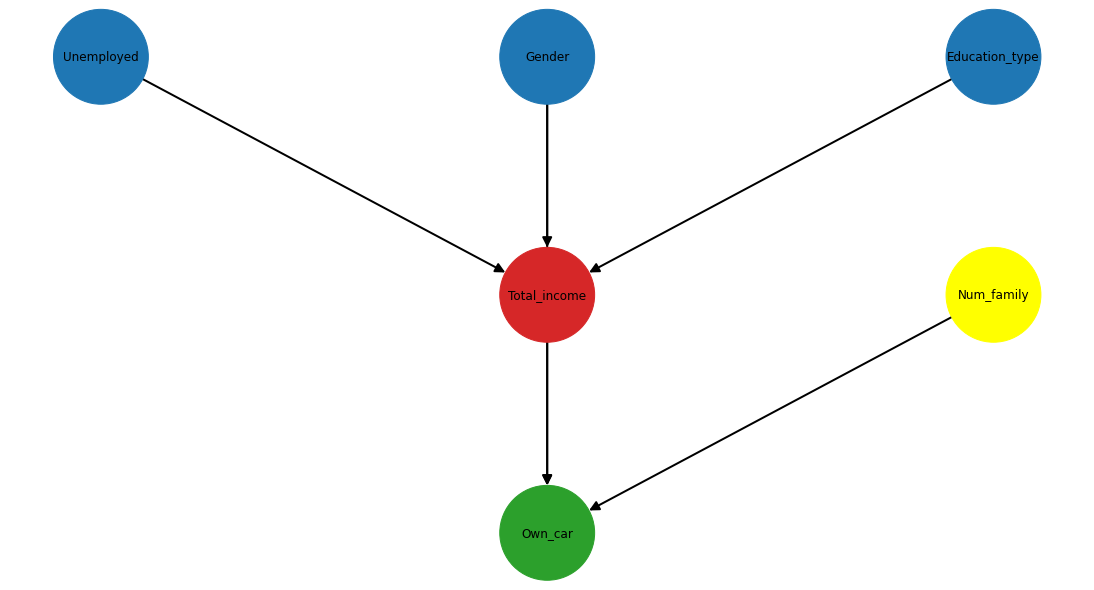

In [18]:
draw_markov_blanket(hillclimb_net_blacklist, "Total_income")

## 7. Illustrating the concept of Flow of Probabilistic Influence

Here we present the concept of probabilistic influence by showing various plots of the refined network. Two variables in a bayesian network $X$ and $Y$ are said to be dependant, or "influenced", given a set of evidential variables $Z$ if it exists a path, or "trail", of nodes $X_i$ that connects $X$ and $Y$, so that for each pair or triplet of nodes in the path, some specific charateristics holds ("active trail"):
 <br>a) $ X_i \to X_{i+1} $(direct descendant)
 <br>b) $ X_{i+1} \to X_i $ (direct parent)
 <br>c) $ X_{i-1} \to X_i \to X_{i+1} $ (descendant)
 <br>d) $ X_{i+1} \to X_i \to X_{i-1} $ (ancestor)
 <br>e) $ X_{i-1} \gets X_i \to X_{i+1} $ (common cause)
 <br>f) $ X_{i-1} \to X_i \gets X_{i+1} $ (common effect or "v-structure")<br>
In order for the trail to be active, in the cases c) to e), $X_i$ have to be non-observed otherwise it would "block" the flow of influence between $ X_{i-1} $ and $X_{i+1}$. Differently, in the case f) either $X_i$ or one of its descendant must be in $Z$. If these condition are not met, and therefore, if there is no active trails between $X$ and $Y$, they are said to be _d-separated_ given $Z$. 

Furthermore we can easily see that due to the symmetry of the conditions, also the concept of influence is symmetrical, thus when indicating a flow between $X$ and $Y$ we usually write $ X \leftrightarrow Y $.
We provided a function to show graphically the flow of influence from a target variable to any other variable in the net given a set of evidential variables. This function employs pgmpy's function <code>active_trail_nodes(target, evidences)</code> to find nodes influenced by the target and then draws the graph by showing:
 - The target variable in **blue**;
 - The influenced variables and the relative connections involved in the active trail in **green**;
 - The observed variables in **pink**;
 - The _d-separated_ variables and the respective inactive edges in **red**.

In [19]:
def display_active_trails(network, target_node, given_nodes=[], nodes_position=pos_hc):
    # Taking all nodes with active trails from target_node with given_nodes as evidence
    active_trail = network.active_trail_nodes(target_node, given_nodes)[target_node]

    # I give a color to all nodes, blue if target, pink if evidence, green if in trails active, red otherwise
    nodes_colors = []
    for node in network.nodes():
        if node == target_node:
            nodes_colors.append("tab:blue")
        elif node in given_nodes:
            nodes_colors.append("pink")
        elif node in active_trail:
            nodes_colors.append("tab:green")
        else:
            nodes_colors.append("tab:red")

    # Same with edges, green if I have an active trail, red otherwise
    edges_colors = []
    edges_weights = []
    for (u, v) in network.edges:
        if u in active_trail and (v in active_trail or v in given_nodes):
            edges_colors.append("tab:green")
            edges_weights.append(4)
        elif u in given_nodes and v == target_node:
            edges_colors.append("tab:green")
            edges_weights.append(4)
        else:
            edges_colors.append("tab:red")
            edges_weights.append(2)

    # Finally I plot the network with colors
    plt.figure(figsize=(20,12.5))
    nx.draw(network, nodes_position, width=edges_weights,
            node_color=nodes_colors, edge_color=edges_colors,
            with_labels=True, node_size=9000, arrowsize=20)

Here we show a generic example of flow of influence over the chosen network, the target node and the given nodes are taken without any particular reason. We can individuate at least an example that of each property that allow a trail to be active. Considering the list mentioned earlier:
<br>a) Age $\to$ Num_family
<br>b) Num_family $\to$ Own_car
<br>c) Gender $\to$ Age $\to$ Num_family
<br>d) Age $\to$ Account_length $\to$ Target (in the path between Num_family and Target)
<br>e) Education_type $\gets$ Age $\to$ Num_family
<br>f) Education_type $\to$ Total_income $\gets$ Unemployed (in the path between Num_family and Target)

Also there's an example of _d-separated_ variable. In fact we have Num_family ⊥ Own_property | {Family_status, Income_type, Total_income} since "Income_type" is given as evidence and thus blocks any active trail going to "Own_property". That's because "Own_property" is a descendant of "Income_type", but if it was its ascendant then condition f would apply and an active trail would be formed.

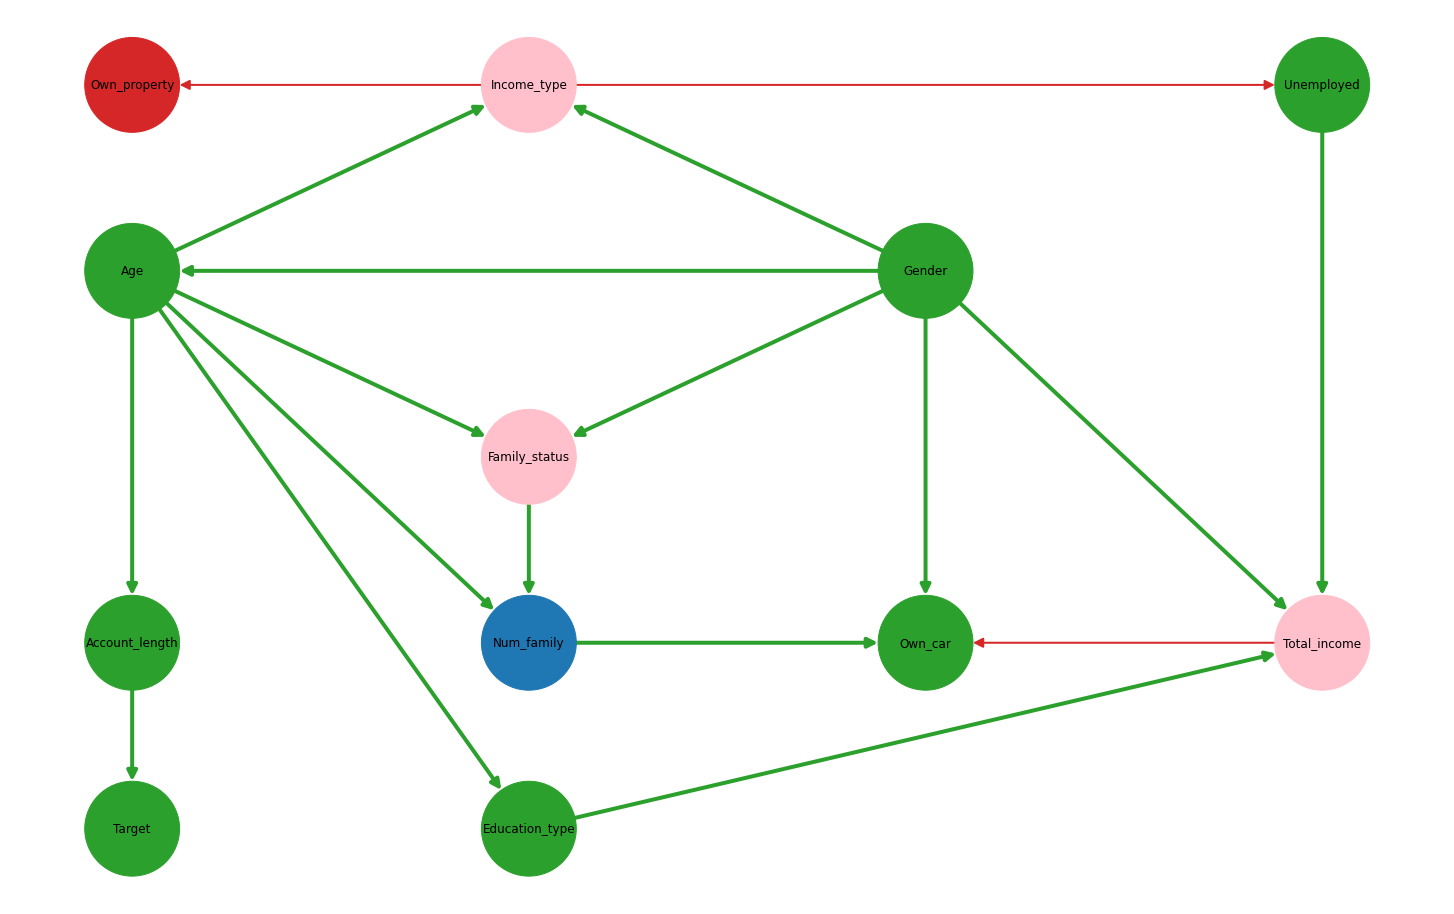

In [20]:
# # generic example
target_node = "Num_family"
given_nodes = ["Family_status", "Income_type", "Total_income"]
display_active_trails(hillclimb_net_blacklist, target_node, given_nodes, pos_hc)

Since the condition of shared effect, or "v-structure" is a bit different from the others, another example is presented:
- the target node is "Num_family";
- the given nodes are "Family_status" and "Age";
Is's possible to observe a v-structure with "vertex" in "Own_car". Usually if an evidence is added, the flow of influence would be disrupted, but in this case, we can see how the flow is extended to the ancestors of "Own_car" and all the variables that are inflenced by them given "Family_status" and "Age".


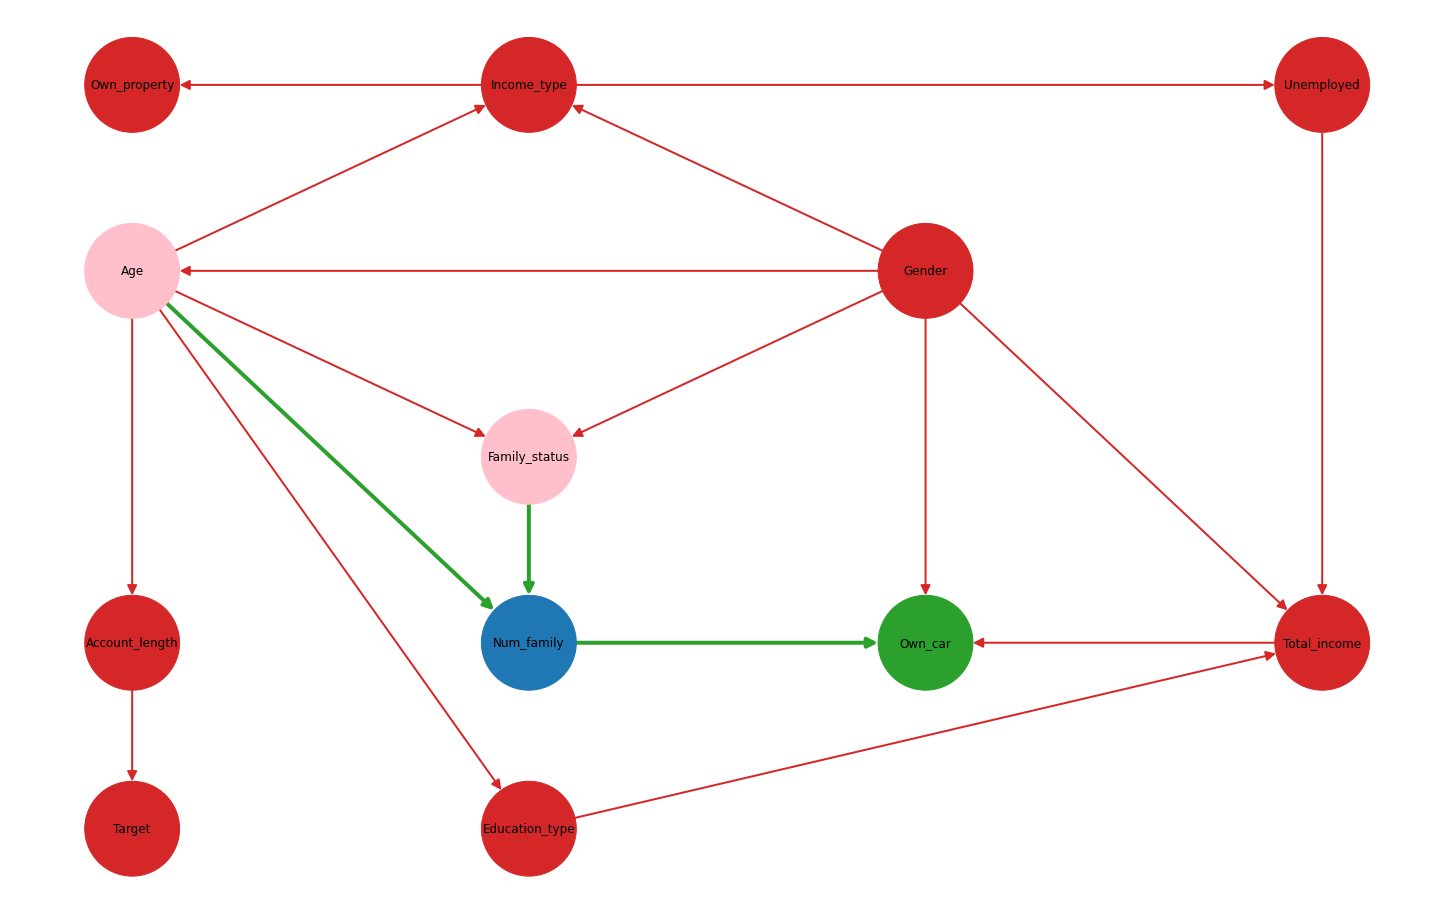

In [22]:
# v_structure
target_node = "Num_family"
given_nodes = ["Family_status", "Age"]
display_active_trails(hillclimb_net_blacklist, target_node, given_nodes, pos_hc)

In order to show how we can propagate the flow of influence interrupted by the v-structures, we can simply add "Own_car" to the evidence, as shown below:

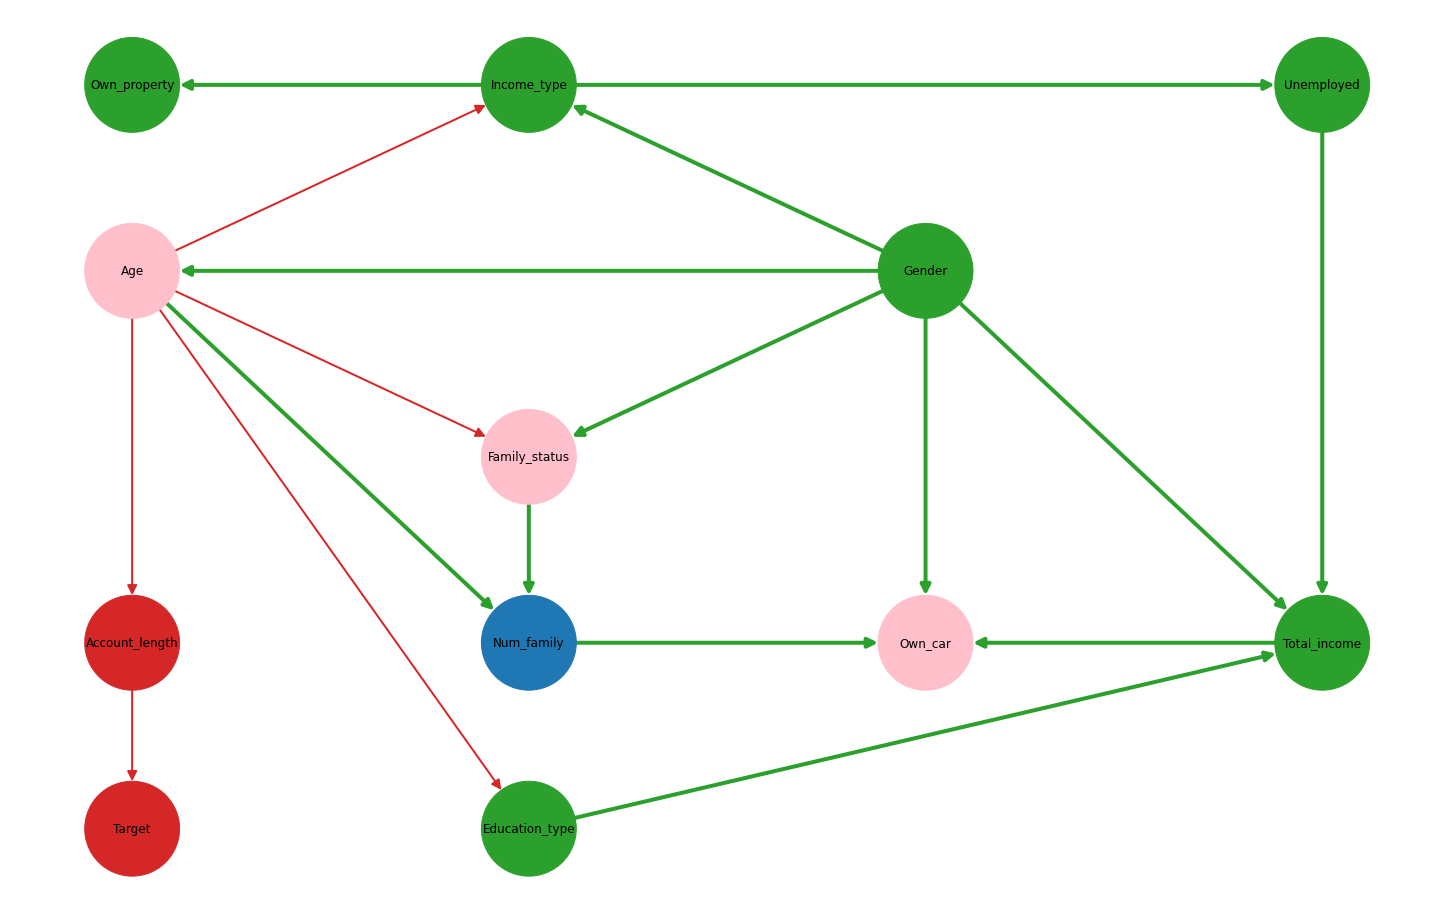

In [23]:
# v_structure
target_node = "Num_family"
given_nodes = ["Family_status", "Age", "Own_car"]
display_active_trails(hillclimb_net_blacklist, target_node, given_nodes, pos_hc)

Furthermore, with the same function, we can show the so called "Local semantics" of the net, which directly follows from the concept of influence and d-separation. By definition, the local semantic of a bayesian net states that a node, given is parents, is independent from all of its non-descendants. This definition can be proven to be completely equivalent to the notion of "global semantic", according to which, being $x_{i}$ variables, $P(x_{1} , ..., x_{n} ) = \prod_{i = 1}^{n} P( x_{i} | Parents(x_{i})). $ 
In the following example we consider "Income_type" and its parents:

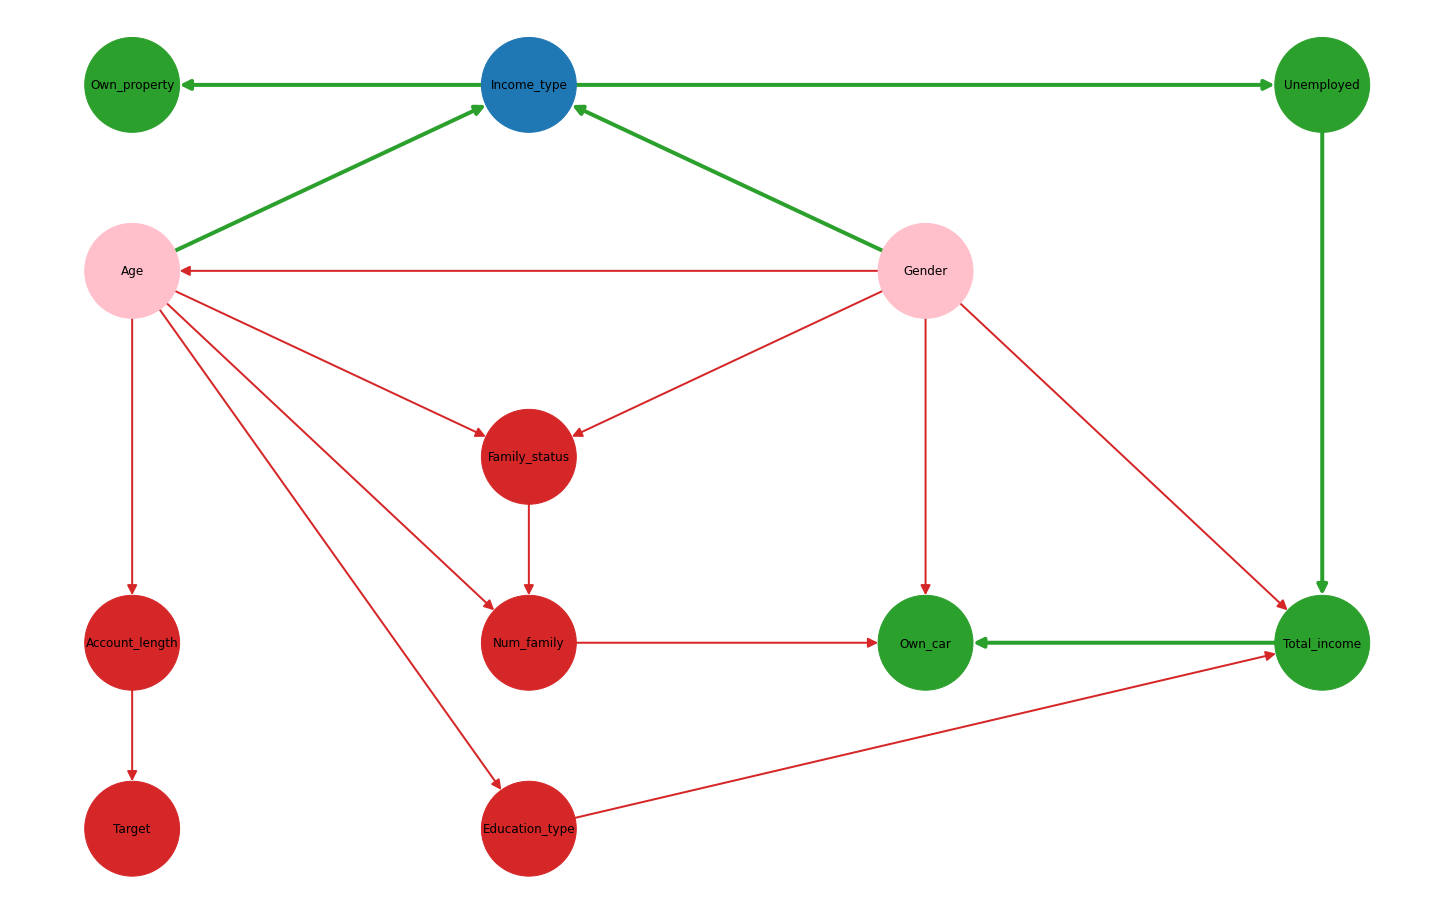

In [24]:
# given the parents, the flow is interrupted except for the discendants
target_node = "Income_type"
given_nodes = hillclimb_net_blacklist.get_parents(target_node)
display_active_trails(hillclimb_net_blacklist, target_node, given_nodes, pos_hc)

Finally, we can also show the main property of the Markov Blanket. In fact, if we consider a variable X and observe all the features in its Markov Blanket, then the flow of influence of X is interrupted with all the other nodes. In other words, X is independent w.r.t. all the other variables of the net, given its Markov Blanket. This property is useful to restrict the number of parameters to be used for inference in big networks. In the following example we consider "Income_type" and
its Markov Blanket, recovered through pgmpy's function <code>get_markov_blanket(node)</code>:

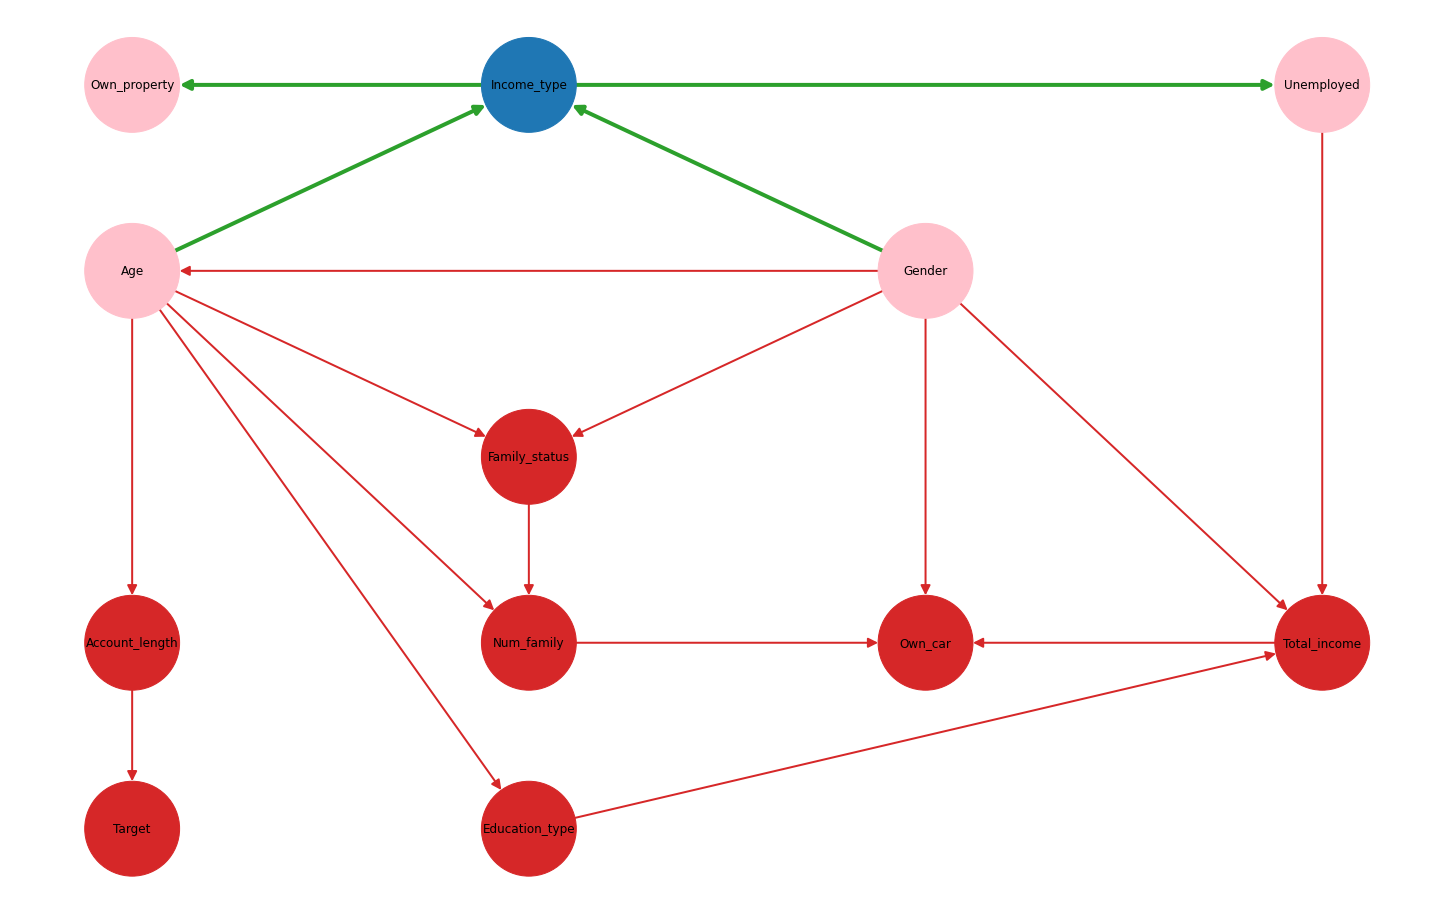

In [25]:
target_node = "Income_type"
given_nodes = hillclimb_net_blacklist.get_markov_blanket(target_node)
display_active_trails(hillclimb_net_blacklist, target_node, given_nodes, pos_hc)

## 8. Show examples of Conditional Probability Tables

A conditional probability table is used to display the conditional probabilities of a single variable with respect to the others (considering dependent variables only). By considering the previously constructed Bayesian Network, the CPTs that are stored are the one for each nodes given the values of its parents, because, given the local semantics of the net, they are sufficient for computing any probability inference on the net.
We can quickly observe this by the plotting the Conditional Probability Distributions given by the <code>pgmpy</code> method <code>get_cpds()</code> over the chosen network. As outcome we will have prior probabilities for "Gender", which has no parents, a 2D CPT for "Age" which has "Gender" as single parent and so on:

In [26]:
for cpd in hillclimb_net_blacklist.get_cpds():
    print(cpd)

+-----------+----------+
| Gender(F) | 0.651096 |
+-----------+----------+
| Gender(M) | 0.348904 |
+-----------+----------+
+--------------+---------------------+-----+-------------------+----------------------+
| Gender       | Gender(F)           | ... | Gender(M)         | Gender(M)            |
+--------------+---------------------+-----+-------------------+----------------------+
| Num_family   | Num_family(1)       | ... | Num_family(4+)    | Num_family(4+)       |
+--------------+---------------------+-----+-------------------+----------------------+
| Total_income | Total_income(high)  | ... | Total_income(low) | Total_income(medium) |
+--------------+---------------------+-----+-------------------+----------------------+
| Own_car(no)  | 0.7507418397626113  | ... | 0.5               | 0.3125               |
+--------------+---------------------+-----+-------------------+----------------------+
| Own_car(yes) | 0.24925816023738873 | ... | 0.5               | 0.6875            

## 9. Show examples of queries in Exact Inference

Queries in Exact Inference are those class of queries that directly rely on the values stored in the CPTs in order to compute the posterior probabilities. In particular we used the <code>VariableElimination</code> function of <code>pgmpy</code> that implements the variable elimination algorithm. The query is computed as the sum of the products of the conditioned probabilities (following the Bayes' Theorem), however, instead of just computing the single factors each time, the latter are stored, in order to achieve better performances.

In [27]:
ve_infer = VariableElimination(hillclimb_net_blacklist)
print("\nAn example: P(Target | Own_property = yes, Own_car = no )")
tick = time.time()
print(ve_infer.query(["Target"], evidence={"Own_property":"yes", "Own_car":"no"}))
print(f"Time needed to perform the query: {time.time() - tick}")


An example: P(Target | Own_property = yes, Own_car = no )


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

+-------------------+---------------+
| Target            |   phi(Target) |
+===================+===============+
| Target(high risk) |        0.1338 |
+-------------------+---------------+
| Target(low risk)  |        0.8662 |
+-------------------+---------------+
Time needed to perform the query: 0.07506799697875977


## 10. Show examples of queries in Approximate Inference

We decided to use the classes <code>ApproxInference</code> and <code>BayesianModelSampling</code> of <code>pgmpy</code> in order to compute queries in approximate inference, meaning that, instead of considering the true CPTs of the network, we perform different kinds of sampling over the net and use the samples to compute an approximation of the distribution of interest.

In particular with <code>ApproxInference</code> we perform queries with forward sampling if there's no evidence, otherwise rejection sampling is used.

Instead we used <code>BayesianModelSampling</code> class because it provides an implementation for likelihood weighted sampling. Differently from <code>ApproxInference</code> we don't have a "query" method, so we needed to recover the probability of interest by computing the weighted frequencies of the samples through the functions <code>put_in_buckets</code> and <code>normalize_dict</code>. 

Respectively the two functions place the summations of the weights for each class of sampled values in a dictionary, and normalize a dictionary with respect to a normalization factor (in our case, the sum of the values in the dictionary). In this way we can obtain a dictionary with keys representing the possible states of the variables and probabilities as values.

Also, in order to show how the number of samples influences both the execution time and the precision of the results, we performed more than one query with different sample sizes (10,100,1000, cardinality of the dataset and 10000)

In [30]:
# code for Rejection Sampling
num_examples = df.shape[0]
approx_infer = ApproxInference(hillclimb_net_blacklist)
n_samples_attempts = [10, 100, 1000, num_examples, 10000]

for ns in n_samples_attempts:
    print(f"An example: P(Target | Own_property = yes, Own_car = no ), performing {ns} samples\n")
    tick = time.time()
    table_result = approx_infer.query(["Target"], evidence={"Own_property":"yes", "Own_car":"no"}, n_samples = ns, show_progress = False)
    print(f"Time needed to perform the query: {time.time() - tick}")
    print(str(table_result) + "\n")

An example: P(Target | Own_property = yes, Own_car = no ), performing 10 samples

Time needed to perform the query: 0.05204606056213379
+-------------------+---------------+
| Target            |   phi(Target) |
+===================+===============+
| Target(high risk) |        0.2000 |
+-------------------+---------------+
| Target(low risk)  |        0.8000 |
+-------------------+---------------+

An example: P(Target | Own_property = yes, Own_car = no ), performing 100 samples

Time needed to perform the query: 0.0520472526550293
+-------------------+---------------+
| Target            |   phi(Target) |
+===================+===============+
| Target(high risk) |        0.1800 |
+-------------------+---------------+
| Target(low risk)  |        0.8200 |
+-------------------+---------------+

An example: P(Target | Own_property = yes, Own_car = no ), performing 1000 samples

Time needed to perform the query: 0.06606054306030273
+-------------------+---------------+
| Target          

In [31]:
# support functions for the likelihood weighting inference method
def put_in_buckets(sample_table, df, vars_to_query, weight_column_name):
    # given weighted samples, this function creates a dictionary with keys: (variable_to_query, sampled_value)
    #                                                           and values: sum(weights_corresponding_to_a_sampled_value)
    # initialization of the dict_of_weights

    # start of the generation of all the possible combinations of keys
    dict_of_weights = {}
    unique_vals_list = []
    for elem in vars_to_query:
        unique_vals_list.append(pd.unique(df[elem]))
    uncomplete_key_entries = itertools.product(*unique_vals_list)

    complete_key_entries = []
    for elem in uncomplete_key_entries:
        current_entry = []
        for index, var in enumerate(vars_to_query):
            current_entry.append(str(var) + ": " + str(elem[index]))
        complete_key_entries.append(tuple(current_entry))
    for key in complete_key_entries:
        dict_of_weights.update({key:0})
    
    # computation of the values as summation of weights

    for index, entry in sample_table.iterrows():
        key_to_use = []
        for elem in vars_to_query:
            key_to_use.append(str(elem)+": "+str(entry[elem]))
        key_to_use.sort()
        tup_key = tuple(key_to_use)
        if dict_of_weights.get(tup_key) != None: #security check
            upd_val = entry[weight_column_name] + dict_of_weights.get(tup_key)
        else:
            upd_val = entry[weight_column_name]
        dict_of_weights.update({tup_key:upd_val})
    return dict_of_weights

def normalize_dict(dict_to_normalize, normalization_factor):
    # given a dictionary with keys: (variable_to_query, sampled_value)
    #                   and values: weights
    # it normalizes all the values with respect to the normalization factor
    for key in dict_to_normalize.keys():
        upd_val = dict_to_normalize.get(key) / normalization_factor
        dict_to_normalize.update({key:upd_val})
    return dict_to_normalize

def tabulate_query_result(normalized_dict):
    # tabulation variables
    headers = [vars_to_query[0], f"phi({vars_to_query[0]})"]
    row_name_list = [key[1] for key in normalized_dict.keys()]
    sum_weights_list = list(normalized_dict.values())
    couple_list = [[row_name_list[i], sum_weights_list[i]] for i in range(0, len(sum_weights_list))]
    couple_list.sort()
    return tabulate(couple_list, headers)

def tabulate_query_result_over_more_vars(normalized_dict, vars_to_query):
    headers = [str(vars_to_query), f"phi({vars_to_query}|Evidence)"]
    rows = [[key, normalized_dict.get(key)] for key in normalized_dict.keys()]
    return tabulate(rows, headers)

In [36]:
# code for likelihood weighting
num_examples = df.shape[0]
vars_to_query = ["Target"]
evidence = [State("Own_property", "yes"), State("Own_car", "no")]
weight_column_name = "_weight"
lw_sampler = BayesianModelSampling(hillclimb_net_blacklist) 
n_samples_attempts = [10, 100, 1000, num_examples, 10000]

for ns in n_samples_attempts:
    print(f"\nAn example: P(Target | Own_property = yes, Own_car = no), performing {ns} samples\n")
    tick = time.time()
    # obtaining samples
    sample_table = lw_sampler.likelihood_weighted_sample(evidence, size = ns)
    # computing normalization factor 
    total_sum_of_weights = sum(sample_table[weight_column_name])
    # obtaining states with unnormalized probabilities
    dict_of_weights = put_in_buckets(sample_table, df, vars_to_query, weight_column_name)
    # normalizing the probabilities
    dict_of_weights = normalize_dict(dict_of_weights, total_sum_of_weights)
    tock = time.time()
    but_the_party_dont_stop = tock - tick
    print(f"Time needed to perform the query: {but_the_party_dont_stop}")
    print(tabulate_query_result_over_more_vars(dict_of_weights, vars_to_query))


An example: P(Target | Own_property = yes, Own_car = no), performing 10 samples



  0%|          | 0/12 [00:00<?, ?it/s]

Time needed to perform the query: 0.048043251037597656
['Target']                phi(['Target']|Evidence)
----------------------  --------------------------
('Target: high risk',)                     0.14453
('Target: low risk',)                      0.85547

An example: P(Target | Own_property = yes, Own_car = no), performing 100 samples



  0%|          | 0/12 [00:00<?, ?it/s]

Time needed to perform the query: 0.051046133041381836
['Target']                phi(['Target']|Evidence)
----------------------  --------------------------
('Target: high risk',)                    0.198991
('Target: low risk',)                     0.801009

An example: P(Target | Own_property = yes, Own_car = no), performing 1000 samples



  0%|          | 0/12 [00:00<?, ?it/s]

Time needed to perform the query: 0.0990898609161377
['Target']                phi(['Target']|Evidence)
----------------------  --------------------------
('Target: high risk',)                    0.133655
('Target: low risk',)                     0.866345

An example: P(Target | Own_property = yes, Own_car = no), performing 9709 samples



  0%|          | 0/12 [00:00<?, ?it/s]

Time needed to perform the query: 0.48638153076171875
['Target']                phi(['Target']|Evidence)
----------------------  --------------------------
('Target: high risk',)                    0.137979
('Target: low risk',)                     0.862021

An example: P(Target | Own_property = yes, Own_car = no), performing 10000 samples



  0%|          | 0/12 [00:00<?, ?it/s]

Time needed to perform the query: 0.5050349235534668
['Target']                phi(['Target']|Evidence)
----------------------  --------------------------
('Target: high risk',)                    0.138901
('Target: low risk',)                     0.861099


## Conclusions

To summarize, we followed a specific workflow in order to obtain a Bayesian Network on the topic of credit card client's reliablity, starting from a relatively simple dataset. This workflow allowed us to create a quite understandable and meaningful model starting from an intuitive representation and refining it through a local search model in a fast way. More than one model was taken into account and they were compared on the basis of their fidelity on the distribution of examples in dataset though the BIC score, but also on the basis of their complexity represented by the number of parameters and their understantablility. Said parameters were extimated from the dataset with a technique involving smoothing in order to deal with missing values. After having chosen the net, some general properties of bayesian networks were shown graphically over the graph representing the network itself. Lastly we performed some queries both with exact and approximate inference method. 

Since the construction process of the networks, both "by hand" and with local search, were data driven, some "flaws" can be individuated:
- **Presence of counterintuitive edges**. As an example we can mention the relation Gender $\to$ Total_income, since in an "ideal world" the gender would not influence the amount of income of a person. However, both the chi-square test and the following refinement round underline this specific relation, which may stem from the well known social problem of the "wage gap" that may be captured by the dataset. 
- **Highly connected features**. Some features, as "Age" or "Gender" are influent on an high number of other features, which is something that increments the complexity of the network and cannot be controlled by the local search algorithm by means of a hyperparameter.
- **Biased probabilities**. Even though it is possible to observe trends that are quite intuitive, the overall performance of the network is highly biased by the proportions of the examples in the dataset. As an example it may happen that a client that possess no property and is unemployed has still a high probability of being reliable:


In [37]:
print("P(Target | Own_property = no, Unemployed = yes ):")
print(ve_infer.query(["Target"], evidence={"Own_property":"no", "Unemployed":"yes"}))

P(Target | Own_property = no, Unemployed = yes ):


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+-------------------+---------------+
| Target            |   phi(Target) |
+===================+===============+
| Target(high risk) |        0.1348 |
+-------------------+---------------+
| Target(low risk)  |        0.8652 |
+-------------------+---------------+


Then, considering the results of both approximate and exact queries, we can observe some expected behaviours:
- When using an approximate method, the more samples are drawn from the distribution, the more the requested joint (conditioned) probabilities will converge towards the values obtained by means of an exact method.
- Since the network is relatively small (containing only 12 nodes) the variable elimination method is actually faster than the sampling methods for the same precision level. 
- For an high number of samples (~9,000-10,000) the likelihood weighting seems to be slower than the rejection sample technique, but this can be explained by the costly operations performed to compute probabilities from samples, involving iteration over a dataframe. A more efficient implementation of those functions could move this result toward the opposite one, as expected by the theory.


In conclusion, the presented method allows to create and query a bayesian net with little knowledge on the domain, which can compactly represent the distribution of data. The data dependency may create some interpretative problems, but also allows to achieve more precise models with respect to "hand-made" models, given that the dataset is enough representative of the real stochastic phenomenon. This last result can be seen by comparing the inferred probabilities from the chosen net and from the hand-made one with the maximum likelihood probabilities directly computed from the dataset (which should be the closest to the real distribution values). This comparison shows how the refined network precisely approximate those values by means of less parameters, which is a desirable property of a net.

In [38]:
# function computing the relative frequencies of the query_vars, given some evidence over a dataset
def rel_freq(df, query_vars, query_evs):
    df_evs = df.loc[(df[list(query_evs)] == pd.Series(query_evs)).all(axis=1)]
    num_samples = len(df_evs)

    unique_list = [tuple(pd.unique(df[var])) for var in query_vars]
    combinations = list(itertools.product(*unique_list))
    
    cpds = {}
    for c in combinations:
        vars_dict = dict(zip(query_vars, c))
        cpds[c]=len(df_evs.loc[(df_evs[query_vars] == pd.Series(vars_dict)).all(axis=1)])/num_samples

    return cpds

In [39]:
# comparing on P(Total_income | Age = "40-49" and Education_type = "Higher education")
ve_infer_hand = VariableElimination(hand_net)
var_query = ["Total_income"]
var_evidence = {"Age":"40-49", "Education_type":"Higher education"}
print(" ***------ Refined net results ------***")
print(ve_infer.query(var_query , evidence=var_evidence))
print(" ***------ Hand made net results ------***")
print(ve_infer_hand.query(var_query , evidence=var_evidence))
print(" ***------ Relative frequencies from data ------***")
rel_f = rel_freq(df, var_query, var_evidence)
print(tabulate_query_result_over_more_vars(rel_f,var_query))

 ***------ Refined net results ------***


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

+----------------------+---------------------+
| Total_income         |   phi(Total_income) |
+======================+=====================+
| Total_income(high)   |              0.4534 |
+----------------------+---------------------+
| Total_income(low)    |              0.2576 |
+----------------------+---------------------+
| Total_income(medium) |              0.2890 |
+----------------------+---------------------+
 ***------ Hand made net results ------***


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+----------------------+---------------------+
| Total_income         |   phi(Total_income) |
+======================+=====================+
| Total_income(high)   |              0.2996 |
+----------------------+---------------------+
| Total_income(low)    |              0.3992 |
+----------------------+---------------------+
| Total_income(medium) |              0.3012 |
+----------------------+---------------------+
 ***------ Relative frequencies from data ------***
['Total_income']      phi(['Total_income']|Evidence)
------------------  --------------------------------
('high',)                                   0.517182
('low',)                                    0.176976
('medium',)                                 0.305842


In [40]:
# comparing on P(Income_type)
var_query = ["Income_type"]
var_evidence = {}
print(" ***------ Refined net results ------***")
print(ve_infer.query(var_query , evidence=var_evidence))
print(" ***------ Hand made net results ------***")
print(ve_infer_hand.query(var_query , evidence=var_evidence))
rel_f = rel_freq(df, var_query, var_evidence)
print(" ***------ Relative frequencies from data ------***")
print(tabulate_query_result_over_more_vars(rel_f,var_query))

 ***------ Refined net results ------***


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+-----------------------------------+--------------------+
| Income_type                       |   phi(Income_type) |
+===================================+====================+
| Income_type(Commercial associate) |             0.2374 |
+-----------------------------------+--------------------+
| Income_type(Pensioner)            |             0.1761 |
+-----------------------------------+--------------------+
| Income_type(State servant)        |             0.0777 |
+-----------------------------------+--------------------+
| Income_type(Student)              |             0.0053 |
+-----------------------------------+--------------------+
| Income_type(Working)              |             0.5035 |
+-----------------------------------+--------------------+
 ***------ Hand made net results ------***


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+-----------------------------------+--------------------+
| Income_type                       |   phi(Income_type) |
+===================================+====================+
| Income_type(Commercial associate) |             0.2367 |
+-----------------------------------+--------------------+
| Income_type(Pensioner)            |             0.1752 |
+-----------------------------------+--------------------+
| Income_type(State servant)        |             0.0800 |
+-----------------------------------+--------------------+
| Income_type(Student)              |             0.0090 |
+-----------------------------------+--------------------+
| Income_type(Working)              |             0.4990 |
+-----------------------------------+--------------------+
 ***------ Relative frequencies from data ------***
['Income_type']              phi(['Income_type']|Evidence)
-------------------------  -------------------------------
('Working',)                                   0.510866
('Comme

C:\Users\NEODOM~1.II\AppData\Local\Temp/ipykernel_20528/2395489905.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_evs = df.loc[(df[list(query_evs)] == pd.Series(query_evs)).all(axis=1)]
